![alt text](images/slides/intro.png)

## Table of Contents
- Intro to PyTorch
    - Hello World
    - Auto Grad
    - Linear Regression
    - Gradient Descent
    - Logistic Regression
    - Data loaders for SGD
    - Two layer neural network
- CNNs
- Image Classification





## Intro to PyTorch

Apart from the general Python imports for math, random, Pandas, and and Numpy, we will import the Torch utilities. These include the torch, torch.nn, and torch.utils for the Dataset loaders.

In [4]:
# import pytorch libraries
%matplotlib inline
import torch 
import torch.autograd as autograd 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd;
import numpy as np;
import random;
import math;

**PyTorch consists of 4 main packages:**

- torch: a general purpose array library similar to Numpy that can do computations on GPU
- torch.autograd: a package for automatically obtaining gradients
- torch.nn: a neural net library with common layers and cost functions
- torch.optim: an optimization package with common optimization algorithms like SGD, Adam, etc

### Hello World in PyTorch

Instead of a traditional "Hello World" print statement, we can check PyTorch is functioning properly by creating and outputing a Tensor.

In [5]:
# Create random tensor
N = 5
x = torch.randn(N, 10).type(torch.FloatTensor)

PyTorch tensors are like Numpy tensors but they can utilize GPUs to accelerate numerical computations.

In [7]:
# reshaping of tensors using .view()
x.view(1,-1) #-1 makes torch infer the second dim

tensor([[ 0.6736,  0.6488, -1.4323, -0.4892, -1.8398, -0.5002,  0.6992,  2.0750,
          1.0564,  0.4420, -1.9077, -0.9362, -0.9655,  1.2114,  2.4377,  1.8508,
          0.4975,  0.1614,  0.5360, -0.3479, -0.5898,  0.3874, -0.8302, -0.7594,
         -0.8495,  0.1700,  1.5493, -0.1895,  0.2229,  0.8790,  0.2944, -1.3832,
          1.0332, -0.0316, -1.5368, -0.5422,  1.2362,  0.0118,  0.7233, -0.3437,
         -1.4607, -1.0255, -1.2584,  0.1984,  0.1661,  0.1159, -0.5904, -1.5080,
          0.7930, -0.3617]])

## Pytorch Autograd

The autograd package in PyTorch automates the computation of backward passes in neural networks. That is, the gradient of the error with respect to all parameters.

In order for this to happen we need to wrapp up our data and paramerers with the aurograd.Variable() function. Each variable has a .grad property which is it’s gradient with respect to our Error function. Each variable also has a .data property which is it the actual value of the tensor.

In [8]:
x = torch.tensor([1., 2., 3., 4., 5., 6.], requires_grad=True)

In [9]:
x.grad

In [10]:
l = (2*x+1).sum()
l

tensor(48., grad_fn=<SumBackward0>)

In [11]:
l.backward()

In [12]:
x.grad

tensor([2., 2., 2., 2., 2., 2.])

## Linear Regression with Pytorch

The goal of linear regression is to fit a line to a set of points.

In [13]:
# Here we generate some fake data
def lin(a,b,x): return a*x+b

def gen_fake_data(n, a, b):
    x = np.random.uniform(0,1,n) 
    y = lin(a,b,x) + 0.1 * np.random.normal(0,3,n)
    return x, y

x, y = gen_fake_data(50, 3., 8.)

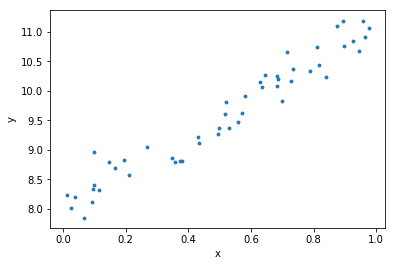

In [14]:
import matplotlib.pyplot as plt
plt.scatter(x,y, s=8); plt.xlabel("x"); plt.ylabel("y");

You want to find parameters (weights) $a$ and $b$ such that you minimize the error between the points and the line $a\cdot x + b$. Note that here $a$ and $b$ are unknown. For a regression problem the most common error function or loss function is the mean squared error.

In [15]:
def mse(y_hat, y): return ((y_hat - y) ** 2).mean()

Suppose we believe $a = 10$ and $b = 5$ then we can compute y_hat which is our prediction and then compute our error.

In [16]:
y_hat = lin(10,5,x)
mse(y_hat, y)

4.59674385024895

In [17]:
def mse_loss(a, b, x, y): return mse(lin(a,b,x), y)

In [18]:
mse_loss(10, 5, x, y)

4.59674385024895

So far we have specified the model (linear regression) and the evaluation criteria (or loss function). Now we need to handle optimization; that is, how do we find the best values for $a$ and $b$? How do we find the best fitting linear regression.


## References

- http://pytorch.org/tutorials/beginner/pytorch_with_examples.html
- https://hsaghir.github.io/data_science/pytorch_starter/
- http://a.sjtume.cn/2017/PyTorch-CNN/
